In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
namesngenre = np.load('./dataset/namesngenre.npy')

In [11]:
namesngenre

array([['Toy Story (1995)',
        'Adventure|Animation|Children|Comedy|Fantasy'],
       ['Jumanji (1995)', 'Adventure|Children|Fantasy'],
       ['Grumpier Old Men (1995)', 'Comedy|Romance'],
       ...,
       ['Elsa & Fred (2005)', 'Comedy|Drama|Romance'],
       ['Tomb Raider (2018)', 'Action|Adventure|Fantasy'],
       ['Fred Armisen: Standup for Drummers (2018)', 'Comedy']],
      dtype='<U158')

In [11]:
ratings_train = np.load('./dataset/ratings_train.npy')

In [13]:
ratings_train.shape

(610, 4980)

In [14]:
ratings_train

array([[ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  2., nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [15]:
np.nanmax(ratings_train)


5.0

In [12]:
np.nanmin(ratings_train)

0.5

# Matrix Factorization

In [34]:
import MF

In [27]:
k = 1

factorization = MF.MF(ratings_train, l=0.01, mu=0.01, k=k)


In [28]:
non_nan_indices = np.where(~np.isnan(ratings_train))
# Separate the row and column indices
row_indices, col_indices = non_nan_indices
R_non_nan = factorization.R[row_indices, col_indices]

In [30]:
factorization.fit(lr_I=0.0001, lr_U=0.0001, num_iterations=100)
prediction_full = factorization.predict()
prediction = prediction_full[row_indices, col_indices]
print(prediction)
factorization.RMSE_(prediction_full)

Iteration 1: Cost = 22388.793390470175. RMSE = 0.838026468135326
Iteration 2: Cost = 22367.741691297226. RMSE = 0.8376289149727438
Iteration 3: Cost = 22346.911891917505. RMSE = 0.8372353672704069
Iteration 4: Cost = 22326.299719696177. RMSE = 0.8368457498704029
Iteration 5: Cost = 22305.901026444753. RMSE = 0.8364599897736218
Iteration 6: Cost = 22285.7117835671. RMSE = 0.8360780160563539
Iteration 7: Cost = 22265.7280774473. RMSE = 0.8356997597908901
Iteration 8: Cost = 22245.94610505204. RMSE = 0.8353251539698958
Iteration 9: Cost = 22226.362169745506. RMSE = 0.8349541334343474
Iteration 10: Cost = 22206.972677298945. RMSE = 0.8345866348048324
Iteration 11: Cost = 22187.774132087532. RMSE = 0.8342225964160238
Iteration 12: Cost = 22168.76313346004. RMSE = 0.8338619582541597
Iteration 13: Cost = 22149.936372278135. RMSE = 0.8335046618973603
Iteration 14: Cost = 22131.29062761099. RMSE = 0.8331506504586327
Iteration 15: Cost = 22112.822763576296. RMSE = 0.8327998685314179
Iteration 16

0.8110262503041126

# Deep Matrix Factorization


In [36]:
import deepMF
import torch
import torch
import torch.nn as nn
import torch.optim as optim
%reload_ext autoreload
%autoreload 2

In [68]:
# Load the input data from a numpy file
ratings_train = np.load('dataset/ratings_train.npy')
ratings_test = np.load('dataset/ratings_test.npy')
# Replace NaN values with 0
ratings_train[np.isnan(ratings_train)] = 0
ratings_test[np.isnan(ratings_test)] = 0

In [69]:
total_data = ratings_train + ratings_test

non_empty_indices = np.where(total_data != 0)
non_empty_indices = np.array([non_empty_indices[0], non_empty_indices[1]])

indices = np.random.choice(np.array(range(non_empty_indices.shape[1])), size=non_empty_indices.shape[1], replace = False)

train_set_indices = indices[0:int(non_empty_indices.shape[1]*0.7)]
train_set_indices2d = np.array(non_empty_indices[:, train_set_indices])
train_set = np.zeros(total_data.shape)
train_set[train_set_indices2d[0], train_set_indices2d[1]] = total_data[train_set_indices2d[0], train_set_indices2d[1]]

test_set_indices = indices[int(non_empty_indices.shape[1]*0.7):]
test_set_indices2d = np.array(non_empty_indices[:, test_set_indices])
test_set = np.zeros(total_data.shape)
test_set[test_set_indices2d[0], test_set_indices2d[1]] = total_data[test_set_indices2d[0], test_set_indices2d[1]]

normalized_train_data = train_set/np.max(train_set)

normalized_test_data = test_set/np.max(test_set)

In [92]:
# Hyperparameters evaluation
encoded_dim = 32
input_size = normalized_train_data.shape 
hidden_size_row = 16
hidden_size_col = 64

In [43]:
optimizers = []
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizers.append((model, optim.Adam(model.parameters(), lr=0.001)))
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizers.append((model, optim.RAdam(model.parameters(), lr=0.001)))
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizers.append((model, optim.AdamW(model.parameters(), lr=0.001)))
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizers.append((model, optim.Rprop(model.parameters(), lr=0.001)))
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizers.append((model, optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)))

for i in range(len(optimizers)):
    deepMF.train_model(optimizers[i][0], optimizers[i][1], torch.FloatTensor(normalized_train_data), weight_decay=i>=5)
    # Pass the new input data through the trained model to get predictions
    predicted_similarity_scores = optimizers[i][0](torch.FloatTensor(normalized_train_data), torch.FloatTensor(normalized_train_data).T)
    target = torch.FloatTensor(train_set)
    print(torch.mean(torch.sqrt((predicted_similarity_scores[target!=0]*5 - target[target!=0])**2)))
    target = torch.FloatTensor(test_set)
    print(torch.mean(torch.sqrt((predicted_similarity_scores[target!=0]*5 - target[target!=0])**2)))

tensor(0.5228, grad_fn=<MeanBackward0>)
tensor(0.7152, grad_fn=<MeanBackward0>)
tensor(0.7113, grad_fn=<MeanBackward0>)
tensor(0.6021, grad_fn=<MeanBackward0>)
tensor(0.6689, grad_fn=<MeanBackward0>)
tensor(0.6710, grad_fn=<MeanBackward0>)
tensor(0.5735, grad_fn=<MeanBackward0>)
tensor(0.7000, grad_fn=<MeanBackward0>)
tensor(0.6967, grad_fn=<MeanBackward0>)
tensor(0.5080, grad_fn=<MeanBackward0>)
tensor(0.7614, grad_fn=<MeanBackward0>)
tensor(0.7689, grad_fn=<MeanBackward0>)
tensor(0.5538, grad_fn=<MeanBackward0>)
tensor(0.6994, grad_fn=<MeanBackward0>)
tensor(0.6960, grad_fn=<MeanBackward0>)


In [55]:
for k in [25, 30, 35, 40]:
    model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col, encoded_dim=k)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    deepMF.train_model(model, optimizer, torch.FloatTensor(normalized_train_data))
    # Pass the new input data through the trained model to get predictions
    predicted_similarity_scores = model(torch.FloatTensor(normalized_train_data), torch.FloatTensor(normalized_train_data).T)
    target = torch.FloatTensor(train_set)
    print(torch.mean(torch.sqrt((predicted_similarity_scores[target!=0]*5 - target[target!=0])**2)))
    target = torch.FloatTensor(test_set)
    print(torch.mean(torch.sqrt((predicted_similarity_scores[target!=0]*5 - target[target!=0])**2)))

tensor(0.5827, grad_fn=<MeanBackward0>)
tensor(0.6748, grad_fn=<MeanBackward0>)
tensor(0.5093, grad_fn=<MeanBackward0>)
tensor(0.7209, grad_fn=<MeanBackward0>)
tensor(0.5753, grad_fn=<MeanBackward0>)
tensor(0.6950, grad_fn=<MeanBackward0>)
tensor(0.5316, grad_fn=<MeanBackward0>)
tensor(0.6955, grad_fn=<MeanBackward0>)


In [94]:
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
deepMF.train_model(model, optimizer, torch.FloatTensor(normalized_train_data), test_data=test_set)

[1.8090029954910278, 1.518591046333313, 1.2772815227508545, 1.091922402381897, 0.9572230577468872, 0.8762134313583374, 0.8367995619773865, 0.8229821920394897, 0.8218688368797302, 0.8224519491195679, 0.8196720480918884, 0.8119210600852966, 0.8003397583961487, 0.7900006771087646, 0.7824667692184448, 0.7808458209037781, 0.7824122309684753, 0.7842073440551758, 0.7834173440933228, 0.7816700339317322, 0.7796587944030762, 0.7785606980323792, 0.7791494727134705, 0.7806158065795898, 0.7812602519989014, 0.7800217270851135, 0.7767158150672913, 0.7721425294876099, 0.7673644423484802, 0.7630724906921387, 0.75959712266922, 0.7566437721252441, 0.7537275552749634, 0.7507810592651367, 0.7479670643806458, 0.7455202341079712, 0.7436509728431702, 0.7425235509872437, 0.742059051990509, 0.7420749068260193, 0.7418891787528992, 0.7408671379089355, 0.7387839555740356, 0.7358809113502502, 0.7327429056167603, 0.7297643423080444, 0.7272637486457825, 0.725273847579956, 0.7237353920936584, 0.7225996851921082, 0.721

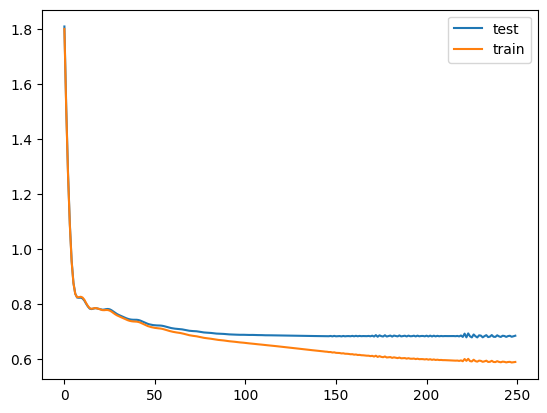

In [96]:
print(model.rmse_test_hist)
print(model.rmse_train_hist)
plt.plot(model.rmse_test_hist, label="test")
plt.plot(model.rmse_train_hist, label="train")
plt.legend()

## Result analysis

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [20]:
!python generate.py --name ./dataset/ratings_train.npy

Ratings loading...
Ratings Loaded.


In [31]:
def plot_cm(targets, predictions, model=None):  
    predictions = predictions[targets!=0]
    targets = targets[targets!=0]
    predictions_strings  = [str(prediction) for prediction in predictions]
    targets_strings  = [str(target) for target in targets]
    # Compute the confusion matrix
    cm = confusion_matrix(targets_strings, predictions_strings)
    
    # Display the confusion matrix as a heatmap
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    if (model is not None):
        plt.title(f"Confusion Matrix, num_epochs={model.num_epochs}, encoded_dim='{model.encoded_dim}'")
    else: 
        plt.title("Confusion Matrix")
    plt.colorbar()
    
    classes = ['0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']  # Replace with your class labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [32]:
def RMSE(targets, predictions):
    predictions = predictions[targets!=0]
    targets = targets[targets!=0]
    # Calculate the squared differences between predictions and targets
    squared_errors = (predictions - targets) ** 2

    # Calculate the mean of squared errors
    mean_squared_error = squared_errors.mean()

    # Calculate the square root to get RMSE
    return np.sqrt(mean_squared_error)

0.8962316760557191


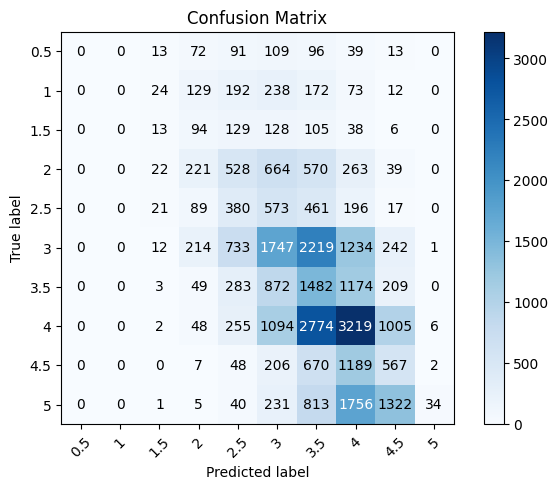

In [49]:
"""
    Use thise cell after running generate.py and assign the used file to calculate the train rmse.

    To have the test RMSE use the test file.
"""

targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = np.load('output.npy')
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions)


tensor(0.0620, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<AddBackward0>)
tensor(0.0619, grad_fn=<A

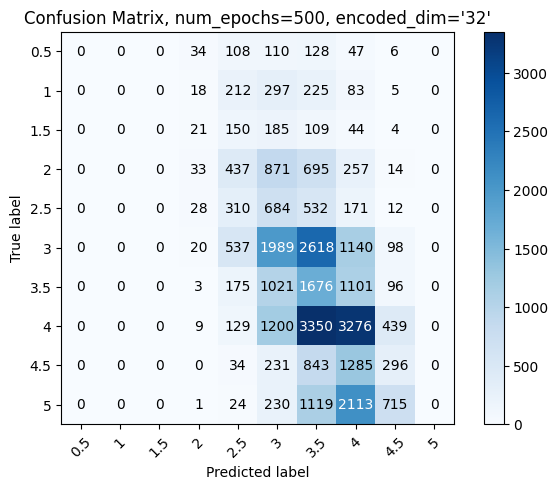

[1.281381368637085, 1.2759783267974854, 1.270686149597168, 1.2654811143875122, 1.2603758573532104, 1.2553561925888062, 1.2504186630249023, 1.2455977201461792, 1.2408915758132935, 1.2362786531448364, 1.231752872467041, 1.2273119688034058, 1.2229570150375366, 1.2186919450759888, 1.2145073413848877, 1.2103917598724365, 1.206339716911316, 1.2023532390594482, 1.1984388828277588, 1.194591760635376, 1.1908074617385864, 1.1870943307876587, 1.1834365129470825, 1.179832935333252, 1.1762868165969849, 1.1727983951568604, 1.1693679094314575, 1.165996789932251, 1.1626781225204468, 1.1594200134277344, 1.156217098236084, 1.1530696153640747, 1.1499675512313843, 1.146924376487732, 1.143934726715088, 1.141000747680664, 1.138121485710144, 1.1352938413619995, 1.1325201988220215, 1.1298000812530518, 1.127120852470398, 1.1244838237762451, 1.1218889951705933, 1.1193352937698364, 1.1168206930160522, 1.1143512725830078, 1.1119203567504883, 1.1095259189605713, 1.1071622371673584, 1.1048314571380615, 1.1025344133

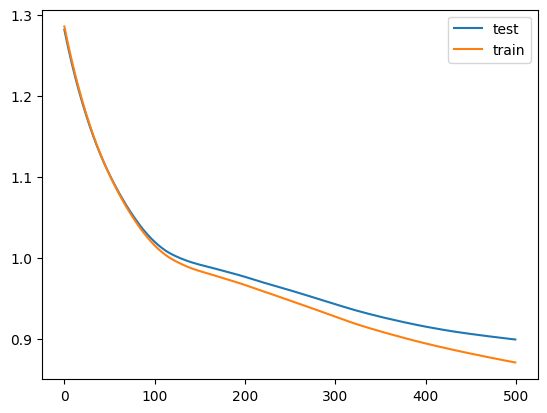

In [117]:
train_set = np.load('./dataset/ratings_train.npy')
train_set[np.isnan(train_set)] = 0
train_set = train_set/np.max(train_set)
test_set = np.load('./dataset/ratings_test.npy')
test_set[np.isnan(test_set)] = 0
encoded_dim = 32
input_size = train_set.shape 
hidden_size_row = 16
hidden_size_col = 64
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col, encoded_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.0001)
deepMF.train_model(model, optimizer, torch.FloatTensor(train_set), num_epochs=1000, lambda_=0.001, mu_=0.001, test_data=test_set)
predicted, _, _ = model(torch.FloatTensor(train_set), torch.FloatTensor(train_set).T) 

targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = model.numpy_and_round(predicted)
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions, model)
print(model.rmse_test_hist)
print(model.rmse_train_hist)
plt.plot(model.rmse_test_hist, label="test")
plt.plot(model.rmse_train_hist, label="train")
plt.legend()



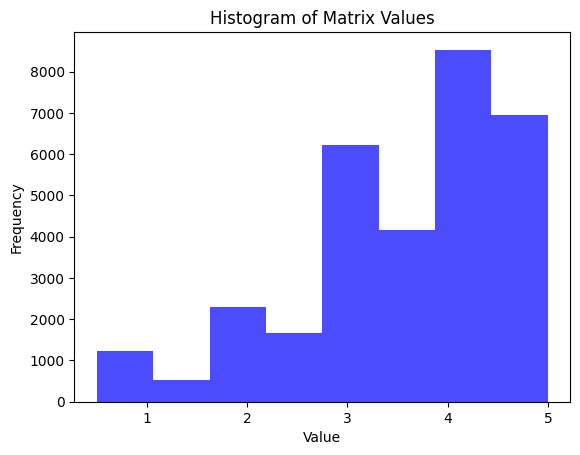

Mean (mu): 3.524605987720742
Standard Deviation (sigma): 1.0326053351746378


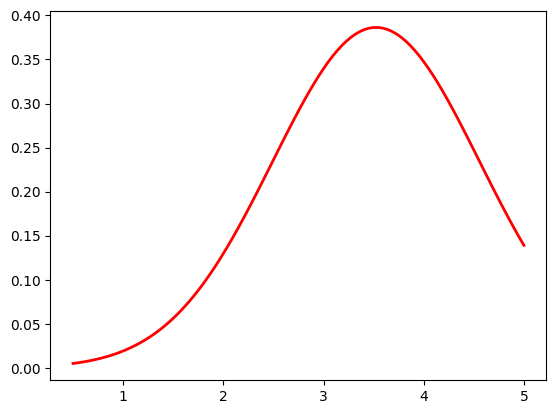

In [57]:
from scipy.stats import norm, fit
# Create the x-axis values for the normal distribution curve
# Flatten the matrix to a 1D array to create the histogram
values = ratings_train.flatten()
values = values[~np.isnan(values)]
# Fit a normal distribution to the histogram
mu, std = norm.fit(values)

# Set the number of bins for the histogram
num_bins = 8

# Create the histogram plot
plt.hist(values, bins=num_bins,color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Matrix Values')
plt.show()
x = np.linspace(min(values), max(values), 100)
pdf = norm.pdf(x, mu, std)

# Plot the histogram
plt.plot(x, pdf, 'r-', linewidth=2)

# Print the parameters of the best-fit normal distribution
print(f"Mean (mu): {mu}")
print(f"Standard Deviation (sigma): {std}")

# PCA 

### Just for analysis


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [70]:
output = np.load('output.npy')
non_normalized_train_data = np.load('./dataset/ratings_train.npy')
non_normalized_train_data[np.isnan(non_normalized_train_data)] = 0
rmse_per_user = []
for line_output, line_test in zip(output, non_normalized_train_data):
    predictions = line_output[line_test!=0]
    targets = line_test[line_test!=0]
    # Calculate the squared differences between predictions and targets
    squared_errors = (predictions - targets) ** 2

    # Calculate the mean of squared errors
    mean_squared_error = squared_errors.mean()

    # Calculate the square root to get RMSE
    rmse_value = np.sqrt(mean_squared_error)
    rmse_per_user.append(rmse_value)
rmse_per_user = np.array(rmse_per_user)
print(rmse_per_user)

[0.66333787 0.72528517 2.0669103  1.09725633 0.72011802 0.7435513
 1.12776028 0.74938254 0.93537051 0.94708929 0.69269608 0.88610116
 0.70134165 0.99416845 1.07235846 0.5398198  0.51231652 0.3981218
 0.76630736 0.81297525 0.78755444 1.47448983 0.62833808 0.45833302
 0.32804264 0.61826666 1.09562838 0.7814491  0.34353513 0.48656703
 0.88518963 0.5863135  0.79107169 1.13118974 0.75546175 0.81534625
 1.28866711 1.00696243 0.80213644 0.73587605 0.97827182 0.82979481
 0.71871456 0.90097254 0.68209773 0.54044766 0.85090331 0.5920148
 0.21801446 0.57831078 0.86517636 0.58911021 0.97149721 0.36326995
 1.330685   0.57812855 0.6984978  0.84800603 0.87541291 0.80745476
 0.76163475 0.59051371 0.74396271 0.6237688  0.34300089 0.55602271
 0.44550718 0.78300145 0.75170555 0.48347617 0.96117281 0.20843708
 0.84019877 0.48955274 1.09621561 1.22600154 1.57190068 0.94945568
 0.62509548 0.41067309 0.99145741 0.80465243 0.91649458 0.60916109
 1.07130938 0.51825541 0.51288341 0.33768824 1.0303031  0.7665217

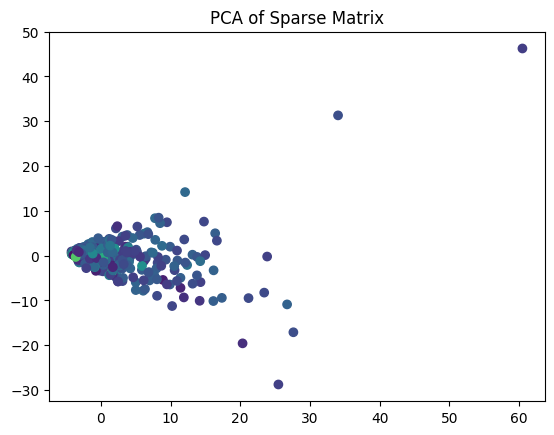

In [71]:
# Generate a random sparse matrix
X = non_normalized_train_data = np.load('./dataset/ratings_train.npy')
X[np.isnan(X)] = 0

n_samples = X.shape[0]
n_features = X.shape[1]

# Perform PCA
n_components = 2  # Number of components to retain
pca = PCA(n_components=n_components)
X_r = pca.fit_transform(X)

# Plot the results
fig = plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], c=rmse_per_user)
plt.title('PCA of Sparse Matrix')
plt.show()


# Add noise to lower-dimensional data
noise_std = 0.1
noise = np.random.normal(0, noise_std, X_r.shape)
noisy_data = X_r + noise

stacked_data = np.vstack((X_r, noisy_data))

# Remap to a higher dimension
remapped_data = np.dot(noisy_data, pca.components_.T)
# Plot the results
fig = plt.figure()
plt.scatter(stacked_data[:, 0], stacked_data[:, 1])
plt.title('Augemnted data in reduced dimension')
plt.show()
